# Explore

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
words = open('data/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [129]:
len(words), min(len(w) for w in words), max(len(w) for w in words)

(32033, 2, 15)

In [3]:
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chars)}
itos = {i:s for i, s in enumerate(chars)}
N = torch.zeros((len(chars), len(chars)), dtype=torch.int32)

for w in words[:]:
    chs = ['.', *list(w), '.']
    for c1, c2 in zip(chs, chs[1:]):
        N[stoi[c1], stoi[c2]] += 1

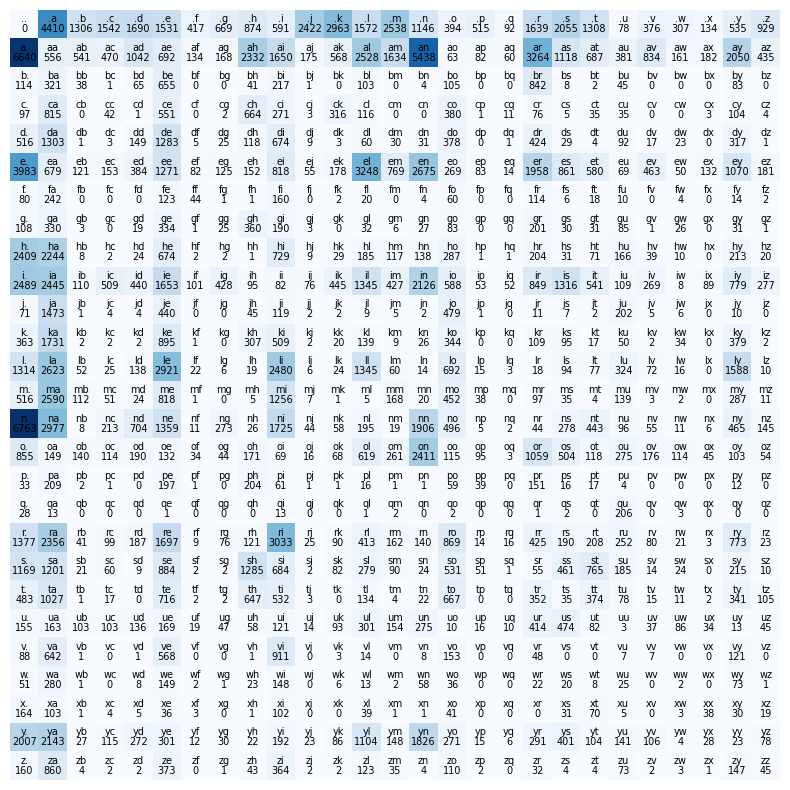

In [131]:
plt.figure(figsize=(10,10))
plt.imshow(N, cmap='Blues')
for i in range(len(chars)):
    for j in range(len(chars)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='black', fontsize=7)
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='black', fontsize=7)
plt.axis('off');

In [165]:
P = (1+N.float()) / N.sum(1, keepdim=True)

In [677]:
g = torch.Generator().manual_seed(42)
#torch.multinomial(p, num_samples=20, replacement=True, generator=g)
for _ in range(5):
    name = ''
    ix = stoi['.']
    while True:
        ix = torch.multinomial(P[ix], num_samples=1, generator=g).item()
        if ix == stoi['.']:
            break
        name += itos[ix]
    print(name)

anugeenvi
s
mabidushan
stan
silaylelaremah


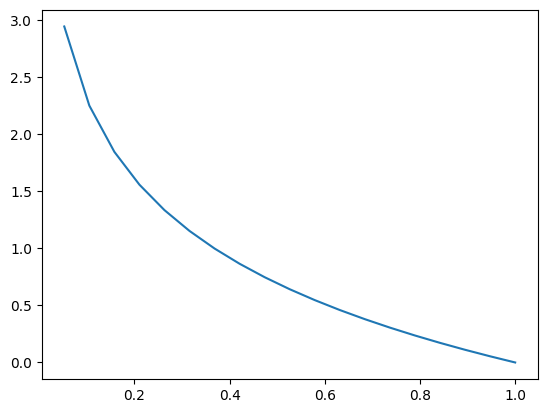

In [153]:
plt.plot(torch.linspace(0, 1, 20), -torch.linspace(0, 1, 20).log())

In [614]:
log_likelihood = 0.
n = 0

for w in words[:]:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        prob = P[ix1, ix2]
        logprob = prob.log()
        log_likelihood += logprob
        n += 1
        ##print(f'{c1}{c2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

log_likelihood=tensor(-559322.6875)
nll=tensor(559322.6875)
nll/n=tensor(2.4516)


### Create training set for bigram model

In [175]:
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        xs.append(ix1)
        ys.append(ix2)
        
        print(c1, c2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs, ys

. e
e m
m m
m a
a .


(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

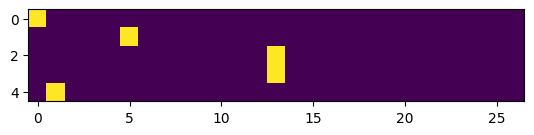

In [182]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
plt.imshow(xenc)

In [218]:
# forward pass

W = torch.randn((27, 27)) # init 27 nuerons, each neuron has 27 inputs
logits = xenc @ W # matrix multiplication, predicts log-counts

# softmax:
counts = logits.exp() # equivalent to rows from N
prob = counts / counts.sum(-1, keepdim=True) # equivalent to rows from P

prob[0]

tensor([0.0171, 0.0073, 0.0523, 0.1103, 0.0120, 0.0543, 0.0282, 0.0075, 0.1255,
        0.0347, 0.0244, 0.0472, 0.0912, 0.0268, 0.0283, 0.0258, 0.0224, 0.0117,
        0.0207, 0.0211, 0.0443, 0.0600, 0.0083, 0.0469, 0.0166, 0.0034, 0.0517])

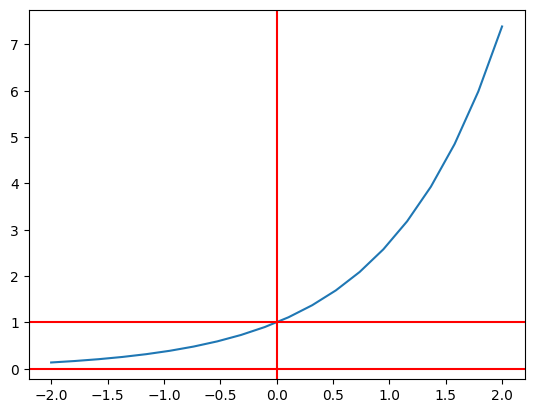

In [199]:
n = 2
plt.plot(torch.linspace(-n, n, 20), torch.linspace(-n, n, 20).exp())
plt.axhline(y = 1, color = 'r', linestyle = '-')
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.axvline(x = 0, color = 'r', linestyle = '-')
# .exp(x) = e^x
# if x < 0: y = between 0 and 1
# if x > 0: y = over 1

# Bigram

In [430]:
xs, ys = [], []

for w in words[:]:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        xs.append(ix1)
        ys.append(ix2)
        
        #print(c1, c2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
#xs, ys
xs.shape, ys.shape

(torch.Size([228146]), torch.Size([228146]))

In [431]:
W = torch.randn((27, 27), requires_grad=True)
B = torch.randn((1, 27), requires_grad=True)

xenc = F.one_hot(xs, 27).float()

In [438]:
lr = 10
steps = 100

for i in range(steps):
    # forward pass
    logits = (xenc @ W) + B
    counts = logits.exp()
    prob = (counts / counts.sum(1, keepdim=True))
    prob = prob[torch.arange(len(ys)), ys]
    #loss = -prob.log().mean()
    loss = -prob.log().mean() + 0.01 * (W**2).mean()
                            #  + 0.01 * (W**2).mean()
                            # smoothing (or regularization)
                            # it slighly pulls probability towards zero
                            # but shouldnt overpower the actual loss
    

    # backward pass
    W.grad = None
    loss.backward()
    W.data += W.grad * -lr
    B.data += B.grad * -lr

    if i % 10 == 0:
        print(f'{i} loss={loss.item():.4f}')
print(f'{i} loss={loss.item():.4f}')

0 loss=2.5152
10 loss=2.5032
20 loss=2.4915
30 loss=2.4771
40 loss=2.5153
50 loss=2.4859
60 loss=2.4881
70 loss=2.4982
80 loss=2.5051
90 loss=2.5123
99 loss=2.5106


In [441]:
g = torch.Generator().manual_seed(3)

for _ in range(5):
    name = ''
    ix = stoi['.']
    while True:
        xen = F.one_hot(torch.tensor([ix]), 27).float()
        logits = (xen @ W) + B
        counts = logits.exp()
        prob = counts / counts.sum(1, keepdim=True)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        if ix == stoi['.']:
            break
        name += itos[ix]
    print(name)

selda
avachaa
araoh
ceremividee
jen


# Trigram 3D (27, 27, 27)

In [502]:
xs, ys = [], []

for w in words[:]:
    chs = ['.', *list(w), '.']
    for c1, c2, c3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        ix3 = stoi[c3]
        xs.append((ix1, ix2))
        ys.append(ix3)
        
        #print(c1, c2, c3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
#xs, ys
xs.shape, ys.shape

(torch.Size([196113, 2]), torch.Size([196113]))

In [503]:
W = torch.randn((27, 27, 27), requires_grad=True)
W.shape

# indexing instead of one_hot:
# logits = W[xs[:, 0], xs[:, 1], ...]
# logits

torch.Size([27, 27, 27])

In [519]:
lr = 10
steps = 200

for i in range(steps):
    # forward pass
    logits = W[xs[:, 0], xs[:, 1], ...]
    counts = logits.exp()
    prob = (counts / counts.sum(1, keepdim=True))
    prob = prob[torch.arange(len(ys)), ys]
    loss = -prob.log().mean() + 0.01 * (W**2).mean()

    # backward pass
    W.grad = None
    loss.backward()
    W.data += W.grad * -lr

    if i % 10 == 0:
        print(f'{i} loss={loss.item():.4f}')
print(f'{i} loss={loss.item():.4f}')

0 loss=2.1987
10 loss=2.1981
20 loss=2.1975
30 loss=2.1970
40 loss=2.1964
50 loss=2.1959
60 loss=2.1953
70 loss=2.1948
80 loss=2.1943
90 loss=2.1937
100 loss=2.1932
110 loss=2.1927
120 loss=2.1922
130 loss=2.1917
140 loss=2.1912
150 loss=2.1907
160 loss=2.1902
170 loss=2.1897
180 loss=2.1892
190 loss=2.1887
199 loss=2.1883


In [520]:
g = torch.Generator().manual_seed(42)

for _ in range(5):
    name = ''
    ix1 = stoi['.']
    ix2 = stoi['.']
    while True:
        logits = W[ix1, ix2, ...]
        counts = logits.exp()
        prob = (counts / counts.sum(0, keepdim=True))
        ix3 = torch.multinomial(prob, num_samples=1, generator=g).item()
        if ix3 == stoi['.']:
            break
        name += itos[ix3]
        ix1 = ix2
        ix2 = ix3
    print(name)

yah
denvi
emmarian
dxfmus
wicklayley


# Trigram 2D (2*27, 27)

In [521]:
xs, ys = [], []

for w in words[:]:
    chs = ['.', *list(w), '.']
    for c1, c2, c3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        ix3 = stoi[c3]
        xs.append((ix1, ix2))
        ys.append(ix3)
        
        #print(c1, c2, c3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = len(ys)
#xs, ys
xs.shape, ys.shape

(torch.Size([196113, 2]), torch.Size([196113]))

In [522]:
# split train/val/test

idxs = torch.randperm(num)
idx_train = idxs[:int(num*0.8)]
idx_val = idxs[int(num*0.8):int(num*0.9)]
idx_test = idxs[int(num*0.9):]

idx_train.shape, idx_val.shape, idx_test.shape

(torch.Size([156890]), torch.Size([19611]), torch.Size([19612]))

In [523]:
W = torch.randn((27*2, 27), requires_grad=True)

xenc_train = F.one_hot(xs[idx_train, :], 27).float().view(-1, 27*2)
xenc_val = F.one_hot(xs[idx_val, :], 27).float().view(-1, 27*2)
xenc_test = F.one_hot(xs[idx_test, :], 27).float().view(-1, 27*2)

y_train = ys[idx_train]
y_val = ys[idx_val]
y_test = ys[idx_test]

W.shape, xenc_train.shape, xenc_val.shape, xenc_test.shape

(torch.Size([54, 27]),
 torch.Size([156890, 54]),
 torch.Size([19611, 54]),
 torch.Size([19612, 54]))

In [528]:
lr = 10
steps = 200

for i in range(steps):
    # forward pass
    logits = xenc_train @ W
    counts = logits.exp()
    prob = (counts / counts.sum(1, keepdim=True))
    prob = prob[torch.arange(len(y_train)), y_train]
    loss = -prob.log().mean() + 0.01 * (W**2).mean()
    

    with torch.no_grad():
        vlogits = xenc_val @ W
        vcounts = vlogits.exp()
        vprob = (vcounts / vcounts.sum(1, keepdim=True))
        vprob = vprob[torch.arange(len(y_val)), y_val]
        val_loss = -vprob.log().mean()
    
    
    #if loss < 2.3:
    #    break
    
    # backward pass
    W.grad = None
    loss.backward()
    W.data += W.grad * -lr
    

        

    if i % 10 == 0:
        print(f'{i} train_loss={loss.item():.4f} | val_loss={val_loss.item():.4f}')
print(f'{i} train_loss={loss.item():.4f} | val_loss={val_loss.item():.4f}')

0 train_loss=2.3173 | val_loss=2.2949
10 train_loss=2.3140 | val_loss=2.2915
20 train_loss=2.3109 | val_loss=2.2884
30 train_loss=2.3081 | val_loss=2.2856
40 train_loss=2.3055 | val_loss=2.2830
50 train_loss=2.3031 | val_loss=2.2807
60 train_loss=2.3009 | val_loss=2.2785
70 train_loss=2.2989 | val_loss=2.2765
80 train_loss=2.2970 | val_loss=2.2747
90 train_loss=2.2953 | val_loss=2.2729
100 train_loss=2.2936 | val_loss=2.2713
110 train_loss=2.2921 | val_loss=2.2698
120 train_loss=2.2907 | val_loss=2.2684
130 train_loss=2.2893 | val_loss=2.2671
140 train_loss=2.2881 | val_loss=2.2659
150 train_loss=2.2869 | val_loss=2.2647
160 train_loss=2.2857 | val_loss=2.2636
170 train_loss=2.2847 | val_loss=2.2626
180 train_loss=2.2837 | val_loss=2.2616
190 train_loss=2.2827 | val_loss=2.2607
199 train_loss=2.2819 | val_loss=2.2599


In [529]:
g = torch.Generator().manual_seed(42)
for _ in range(5):
    name = ''
    ix1 = stoi['.']
    ix2 = stoi['.']
    while True:
        
        xen = F.one_hot(torch.tensor((ix1, ix2)), 27).float().view(-1, 27*2)
        logits = xen @ W
        counts = logits.exp()
        prob = (counts / counts.sum(1, keepdims=True))
        ix3 = torch.multinomial(prob, num_samples=1, generator=g).item()
        if ix3 == stoi['.']:
            break
        name += itos[ix3]
        ix1 = ix2
        ix2 = ix3
    print(name)

anuguen
tis
aabidushan
ubra
ullayley
